# TensorFlow 자습서 #03-B
# Layers API

원저자 [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ) / 번역 곽병권

## 개요

TensorFlow에서 신경망을 만들 때 빌더 API를 사용하는 것이 중요합니다. 왜냐하면 소스 코드를 쉽게 구현하고 수정할 수 있기 때문입니다. 이것은 또한 오류의 가능성을 낮추어 줍니다.

본장 이외의 자습서의 대부분은 PrettyTensor라는 TensorFlow 빌더 API를 사용하여 신경망을 쉽게 만들 수 있습니다. TensorFlow에 사용할 수 있는 여러 가지 빌더 API가 있습니다. PrettyTensor는 2016년 중반의 시점에 TensorFlow에서 가장 완벽하고 세련된 빌더 API였기 때문에이 자습서에서 사용 되었습니다. 그러나 PrettyTensor는 Google에서 일하는 한 명의 개인에 의해서만 개발되었으며 독특하고 우아한 기능이 있지만 향후에 더 이상 사용되지 않을 수 있습니다.

이 자습서는 최근 TensorFlow 버전 1.1에 추가 된 작은 빌더 API에 대한 것 입니다. 이것은 단순히 *Layers* 또는 *Layers API* 또는 Python 이름 `tf.layers`로 불립니다. 이 빌더 API는 TensorFlow의 일부로 자동 설치되므로 PrettyTensor에서 필요했던 별도의 Python 패키지를 설치할 필요가 없습니다.

이 튜토리얼은 PrettyTensor의 Tutorial #03과 매우 유사하며 Layers API를 사용하여 동일한 컨볼루션 신경망을 구현하는 방법을 보여줍니다. 컨볼루션 신경망에 관한 튜토리얼 #02을 미리 보고 이 장을 살펴보시기 바랍니다.

## 흐름도

다음 차트는 아래에 구현 된 컨볼루션 신경망의 데이터 흐름을 대략적으로 보여줍니다. 컨볼루션에 대한 자세한 설명은 자습서 #02를 참조하십시오.

![Flowchart](images/02_network_flowchart.png)

입력 이미지는 필터 웨이트를 사용하여 첫 번째 컨볼루션 레이어에서 처리됩니다. 결과적으로 16 개의 새로운 이미지가 생성되며, 하나는 컨볼루션 레이어의 각 필터에 해당합니다. 이미지는 또한 다운 샘플링되므로 이미지 해상도가 28x28에서 14x14로 감소합니다.

이 16 개의 작은 이미지는 두 번째 컨볼루션 레이어에서 처리됩니다. 이 16 개의 채널마다 필터 가중치가 필요하며 이 레이어의 각 출력 채널에 대해 필터 가중치가 필요합니다. 36 개의 출력 채널이 있으므로 두 번째 컨볼루션 레이어에는 총 16 x 36 = 576 개의 필터가 있습니다. 결과 이미지는 다시 7x7 픽셀로 다운 샘플링됩니다.

두번째 컨볼루션 레이어의 출력은 각각 7x7 픽셀의 36장의 이미지가 됩니다. 그런 다음 길이가 7 x 7 x 36 = 1764 인 단일 벡터로 평탄화되며, 이는 128 개의 뉴런이 있는 완전 연결된 레이어의 입력으로 사용됩니다. 이것은 이미지의 클래스, 즉 어떤 숫자가 이미지에 묘사되어 있는지를 결정하는 데 사용되는 각 클래스에 하나씩, 10 개의 뉴런을 가진 완전히 연결된 또 다른 레이어로 공급됩니다.

컨볼루션 필터는 처음에 무작위로 선택되므로 분류가 무작위로 수행됩니다. 입력 이미지의 예측 클래스와 참 클래스 간의 오차는 소위 교차 엔트로피 (cross-entropy)로 측정됩니다. 그런 다음 옵티마이저가 미분의 체인 규칙을 사용하여 컨볼루션 네트워크를 통해, 이 오류를 자동으로 전파하고 분류 오류를 개선하기 위해 필터 가중치를 업데이트합니다. 이것은 분류 오류가 충분히 낮을 때까지 반복적으로 수천 번 반복됩니다.

이 특정 필터 가중치와 중간 이미지는 한 번의 최적화 실행 결과이며이 노트북을 다시 실행하면 다르게 보일 수 있습니다.

TensorFlow의 계산은 실제로 단일 이미지 대신 이미지 일괄 처리로 수행되므로 계산이 더 효율적입니다. 즉, TensorFlow에서 구현 될 때 순서도에는 실제로 하나 이상의 데이터 차원이 있습니다.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math

이 문서는 Python 3.6.1 (Anaconda) 및 아래의 TensorFlow 버전을 사용하여 개발되었습니다.

In [2]:
tf.__version__

'1.4.0'

## Load Data

MNIST 데이터 세트는 약 12MB이며 주어진 경로에 위치하지 않으면 자동으로 다운로드됩니다.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터 세트는 현재 로드 되었으며 70.000개의 이미지 및 관련 라벨 (즉, 이미지의 분류)로 구성됩니다. 데이터 집합은 3개의 상호 배타적인 하위 집합으로 나뉩니다. 이 튜토리얼에서는 훈련 및 테스트 세트 만 사용합니다.

In [4]:
print("크기:")
print("- 훈련 세트:\t\t{}".format(len(data.train.labels)))
print("- 테스트 세트:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

크기:
- 훈련 세트:		55000
- 테스트 세트:		10000
- Validation-set:	5000


클래스 레이블은 One-Hot로 인코딩 됩니다. 즉, 각 레이블은 하나의 요소를 제외하고 모두 0인 요소가 포함 된 10개의 벡터입니다. 이 요소의 색인은 클래스 번호, 즉 연관된 이미지에 표시된 숫자입니다. 테스트 집합에 대한 클래스 수를 정수로 필요로 하므로 지금 계산합니다.

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

데이터 차원은 아래 소스 코드의 여러 위치에서 사용됩니다. 그것들은 한 번 정의되어 있으므로 아래의 소스 코드에서 숫자 대신 이러한 변수를 사용할 수 있습니다.

In [6]:
# MNIST 데이터는 이미지의 한 변이 28 픽셀입니다.
img_size = 28

# 이미지는 각 변의 크기를 곱한 수의 일차원 배열로 표현이 됩니다.
img_size_flat = img_size * img_size

# 높이와 넓이로 구성된 튜플은 이미지를 재구성하기 위해서 필요합니다.
img_shape = (img_size, img_size)

# 이미지의 컬러 채널의 수: 1 그레이 스케일 이미지의 경우 1
num_channels = 1

# 클래스의 수, 클래스는 0~9까지의 숫자를 의미합니다.
num_classes = 10

### 이미지를 그리는 도움 함수

3x3그리드에 9개의 이미지를 플롯하고 각 이미지 아래에 참 및 예측 클래스를 쓰는 데 사용되는 함수입니다.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 일부의 이미지를 그려서 데이터가 정확한지 확인해 봅니다.¶

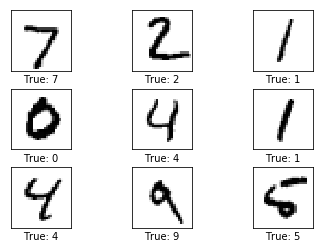

In [8]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

TensorFlow의 목적은 동일한 계산이 파이썬에서 직접 수행되는 것보다 훨씬 효율적으로 실행될 수있는 소위 연산 그래프를 구성하는 것입니다. TensorFlow는 실행해야 하는 전체 연산 그래프를 알고 있기 때문에 NumPy보다 더 효율적입니다. NumPy는 한 번에 하나의 수학 연산 만 계산합니다.

또한 TensorFlow는 그래프의 변수를 최적화하여 모델의 성능을 향상시키는 데 필요한 그래디언트를 자동으로 계산할 수 있습니다. 이것은 그래프가 간단한 수학적 표현의 조합이기 때문에 전체 그래프의 그래디언트가 미분에 대한 체인 규칙을 사용하여 계산 될 수 있기 때문입니다.

TensorFlow는 GPU뿐 아니라 멀티 코어 CPU를 활용할 수도 있습니다. Google은 TPU (Tensor Processing Units)라고 불리는 TensorFlow 용 특수 칩을 구축했으며 GPU보다 훨씬 빠릅니다.

TensorFlow 그래프는 아래에 설명 된 다음 부분으로 구성됩니다.

* Placeholder 변수: 변경되는 값을 입력으로 사용할 수 있도록 합니다.
* 모델 변수: 모델이 더 좋은 성능을 내도록 최적화 할 수 있습니다.
* 모델은 본질적으로 Placeholder 변수와 모델 변수의 입력이 제공되면 출력을 계산하는 수학 함수입니다.
* 비용: 변수들을 최적화 하기 위해서 사용되는 측정값 입니다.
* 최적화 기법: 모델의 변수를 변경합니다.

또한 TensorFlow 그래프는 다양한 디버깅 문을 포함 할 수 있습니다. 이 노트북에서는 다루지 않지만 TensorBoard를 사용하여 데이터를 표시하도록 로깅합니다.

## Placeholder 변수

Placeholder 변수는 그래프를 실행할 때마다 변경할 수 있는 TensorFlow 계산 그래프의 입력 값 역할을 합니다.

먼저 입력 이미지의 placeholder 변수를 정의합니다. 이를 통해 TensorFlow 그래프에 입력되는 이미지를 변경할 수 있습니다. 이것은 소위 텐서 (tensor)라고 불리는데, 이는 그것이 다차원 벡터 또는 행렬이라는 것을 의미합니다. 데이터 형은 float32로 설정되고 형태는 `[None, img_size_flat]`으로 설정됩니다. 여기서 `None`은 텐서가 임의의 수의 이미지를 보유 할 수 있음을 의미합니다. 각 이미지는 길이가 `img_size_flat`인 벡터입니다.

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

콘볼루션 레이어는 `x`가 4 차원 텐서로 인코딩 될 것으로 요구하므로 모양을 바꿔야 합니다. 요구되는 형태는 `[num_images, img_height, img_width, num_channels]`이 됩니다. 첫 번째 차원은 -1을 사용하여 자동으로 추론 할 수 있습니다. 따라서 재구성 작업은 다음과 같습니다.

In [10]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

다음으로 우리는 placeholder `x`에 입력 된 이미지와 관련된 실제 레이블에 대한 placeholder 변수를 갖습니다. 이 placeholder 변수의 모양은`[None, num_classes]`입니다. 이는 임의의 수의 레이블을 보유 할 수 있음을 의미하며 각 레이블은 이 경우에는 길이가 `num_classes`인 벡터입니다.

In [11]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

클래스 번호에 대한 placeholder 변수를 사용할 수도 있지만 대신 argmax를 사용하여 이를 계산합니다. 이 값은 TensorFlow 연산자이므로 이 시점에서는 아무 것도 계산되지 않습니다.

In [12]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


## PrettyTensor 구현

이 섹션에서는 튜토리얼 #03에서 가져온 PrettyTensor를 사용하는 컨볼루션 신경망 구현을 보여줍니다. 따라서 아래 Layers API를 사용한 구현과 비교할 수 있습니다. 이 코드는 `if False:` 블록으로 묶여 있으므로 여기서는 실행되지 않습니다.

기본 개념은 새로운 연산 Layer를 추가하여 전체 컨볼루션 신경망을 생성하는 도움 함수가 있는 PrettyTensor 객체로 입력 텐서 `x_image`를 감싸는 것 입니다. 이것은 매우 간단하고 우아한 구문입니다.

In [13]:
if False:
    x_pretty = pt.wrap(x_image)

    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

## Layers 구현

이제 TensorFlow 버전 1.1 이후에 포함 된 Layers API를 사용하여 동일한 컨볼루션 신경망을 구현합니다. PrettyTensor보다는 많은 코드가 필요합니다. 대부분의 코드는 상당량은 넘겨주어야 할 매개변수의 설명에 해당합니다.

신경망을 구축하는 동안 마지막 레이어를 참조하기 위해 `net`-변수를 사용합니다. 다양한 실험을 하려는 경우 코드에서 레이어를 쉽게 추가하거나 제거 할 수 있습니다. 먼저 `net` 변수에 형태를 변경한 입력 이미지를 설정합니다.

In [14]:
net = x_image

그러면 입력 이미지는 크기가 5x5 픽셀 인 각각 16개의 필터가있는 첫 번째 컨볼 루션 레이어에 입력됩니다. 활성화 함수는 Rectified Linear Unit(ReLU)이고, 이에 대해서는 자습서 2장에서 자세히 설명되어 있습니다.

In [15]:
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)

이러한 방식으로 신경망을 구성하는 장점 중 하나는 레이어에 대한 참조를 쉽게 추출 할 수 있다는 것입니다. 이것은 PrettyTensor 같은 경우에는 조금 더 복잡합니다.

더 아래에서 첫 번째 컨볼루션 레이어의 출력을 플롯해야 하므로 해당 레이어를 참조하는 또 다른 변수를 만듭니다.

In [16]:
layer_conv1 = net

우리는 이제 컨볼루션 레이어의 출력에서 max-pooling을 수행합니다. 이것은 자습서 #02에 상세히 설명되어 있습니다.

In [17]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

이제 각각 5 x 5 픽셀의 36 개의 필터와 ReLU 활성화 함수를 가진 두 번째 컨볼루션 레이어를 추가합니다.

In [18]:
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)

또한 이 컨볼루션 레이어의 출력을 시각화 하려는 것이므로 나중에 사용할 수 있도록 참조를 유지합니다.

In [19]:
layer_conv2 = net

두번째 컨볼루션 계층의 출력은 이미지를 다운 샘플링하기 위해 max-pool을 적용합니다.

In [20]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

이 max-pooling에 의해 출력되는 텐서는 다음에 보이는 것과 같이 랭크가 4가 됩니다.

In [21]:
net

<tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 7, 7, 36) dtype=float32>

다음으로 신경망에 완전히 연결된 레이어를 추가하려고합니다. 하지만 이 레이어는 입력으로 랭크가 2인 텐서가 필요하므로 먼저 텐서를 평평하게 해야합니다.

`tf.layers` API는 TensorFlow Core로 옮겨오기 전에 먼저 tf.contrib.layers에 위치 했습니다. 그런데, TensorFlow 개발자가 무려 1년에 걸쳐 이 간단한 함수를 이전 했음에도 불구하고 더 단순한 flatten() 함수를 함께 옮기는 것을 잊어 버렸습니다. 그래서 우리는 여전히 `tf.contrib.layers`를 사용해야 합니다.

In [22]:
net = tf.contrib.layers.flatten(net)

# This should eventually be replaced by:
# net = tf.layers.flatten(net)

아래에 보이는 것 처럼, 랭크가 2인 텐서로 평탄화를 했습니다.

In [23]:
net

<tf.Tensor 'Flatten/flatten/Reshape:0' shape=(?, 1764) dtype=float32>

이제 완전히 연결된 레이어를 신경망에 추가 할 수 있습니다. 이것은 레이어 API에서 *dense* 레이어라고 부릅니다.

In [24]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)

입력 이미지를 10 개의 다른 클래스로 분류하기 위해서는 신경망이 필요합니다. 따라서 마지막으로 완전히 연결된 레이어에는 `num_classes=10` 출력 뉴런이 있습니다.

In [25]:
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

마지막으로 완전히 연결된 레이어의 출력을 logits이라고도 하며, 우리는 편의상 logits이라는 변수를 사용하겠습니다.

In [26]:
logits = net

우리는 softmax 함수를 사용하여 출력을 변형하여('스쿼시')하여 0과 1 사이에 있도록 하고, 총합이 1이 되도록 합니다.

In [27]:
y_pred = tf.nn.softmax(logits=logits)

이것은 뉴럴 네트워크가 입력 이미지가 각 가능한 클래스에 있다고 생각 할 가능성이 얼마나 높은지를 알려줍니다. 가장 높은 가치를 가진 것이 가장 가능성이 높은 것으로 간주되므로 해당 색인을 클래스 번호로 간주합니다.

In [28]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

우리는 이제 TensorFlow 직접 구현하는 경우 여러 복잡한 코드 행을 필요로 하는 것을, 단 몇 줄의 코드로 정확히 동일하게 동작하는 컨볼루션 신경망을 만들었습니다.

Layers API는 어쩌면 PrettyTensor만큼 우아하지는 않지만 다른 장점이 있습니다. 예를 들어, 중간 계층을 보다 쉽게 참조 할 수 있으며 계층 API를 사용하여 분기 및 다중 출력을 사용하여 신경망을 구성하는 경우 쉽게 할 수 있습니다.

### 손실함수의 최적화

입력 이미지를 분류 할 때 모델의 성능을 높이려면, 컨볼루션 신경망의 내부의 변수를 최적화 해야만 합니다.

교차 엔트로피는 분류에 사용되는 성능 측정 값입니다. 교차 엔트로피는 항상 양의 연속 함수이며 모델의 예측 된 출력이 원하는 출력과 정확하게 일치하면 교차 엔트로피는 0입니다. 따라서 최적화의 목표는 교차 엔트로피를 최소화하여 모델의 변수를 최적화 하여 가능한 한 0에 가까워 지도록하는 것입니다.

TensorFlow는 cross-entropy를 계산하는 함수를 가지고 있습니다.이 함수는 내부적으로 softmax를 계산하기 때문에 수치 안정성을 향상시키기 위해 `logits`-layer의 값을 사용합니다.

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

이제 각각의 이미지 분류에 대한 교차 엔트로피를 계산 했으므로 모델이 각 이미지에서 얼마나 잘 작동하는지 측정 할 수 있습니다. 그러나 교차 엔트로피를 사용하여 모델 변수의 최적화를 유도하려면 단일 스칼라 값이 필요하므로 모든 이미지 분류에 대해 교차 엔트로피의 평균을 취합니다.

In [30]:
loss = tf.reduce_mean(cross_entropy)

### 최적화 방법

이제 비용 측정 방법을 알았고 이를 최소화하는 최적화 도구를 만들 수 있습니다. 여기서는 학습 속도를 1e-4로 하고 Adam optimizer를 사용하겠습니다.

이 시점에서 최적화는 수행되는 것은 아닙니다. 사실, 아무것도 계산되지 않습니다. 나중에 실행을 위해 TensorFlow 그래프에 최적화 개체를 추가만 했습니다.

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### 분류 정확도

진행 상황을 사용자에게 보고 할 수 있도록 분류 정확도를 계산합니다.

먼저 예측 클래스가 각 이미지의 실제 클래스와 같은지 여부를 알려주는 부울 값의 벡터를 만듭니다.

In [32]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

분류 정확도는 진리값을 실수로 형변환하여 거짓이 0으로 True가 1이되도록 한 다음이 전체의 평균을 구합니다.

In [33]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 가중치 얻어오기

아래에서 우리는 컨볼루션 레이어의 가중치를 시각화하려고 합니다. TensorFlow 구현에서는 변수를 직접 만들었으므로 직접 참조가 가능했습니다. 그러나 `tf.layers`와 같은 빌더 API를 사용하는 경우에는, 레이어의 모든 변수는 빌더 API에 의해 간접적으로 생성됩니다. 따라서 TensorFlow에서 변수를 검색해야합니다.

먼저 TensorFlow 그래프에 변수 이름 목록이 필요합니다.

In [34]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print(var)

<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'layer_fc_out/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam_1:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/ke

각 컨볼루션 레이어에는 두 가지 변수가 있습니다. 첫 번째 콘볼루션 레이어의 경우 `layer_conv1/kernel:0`과 `layer_conv1/bias:0`으로 명명됩니다. `kernel` 변수는 우리가 저 아래에서 시각화하기를 원하는 변수입니다.

우리가 다른 목적으로 설계된 TensorFlow 함수 `get_variable ()`을 사용해야 하기 때문에, 이 변수에 대한 참조를 얻는 것은 다소 어색하지만, 그렇게 하지 않으면 새 변수를 만들거나 기존 변수를 다시 사용해야 합니다. 가장 쉬운 방법은 다음 도움 함수를 만드는 것입니다.

In [35]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

이 도움 함수를 사용하여 변수를 검색 할 수 있습니다. TensorFlow 개체입니다. 변수의 내용을 얻으려면 아래에서 더 자세히 설명하는 것처럼 `content = session.run(weights_conv1)`과 같은 것을 해야 합니다.

In [36]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

## TensorFlow 실행

### TensorFlow session 만들기

TensorFlow 그래프가 생성되면 그래프를 실행하는 데 사용되는 TensorFlow 세션을 만들어야 합니다.

In [37]:
session = tf.Session()

### 변수 초기화

`weights`와 `biases`등의 변수는 최적화를 시작하기 전에 초기화되어야합니다.

In [38]:
session.run(tf.global_variables_initializer())

### 최적화 반복을 수행하는 도움 함수

트레이닝 세트에는 55,000 개의 이미지가 있습니다. 이 모든 이미지를 사용하여 모델의 그래디언트를 계산하는 것은 시간이 꽤 오래 걸립니다. 따라서 우리는 옵티 마이저의 각 반복에서 작은 배치 이미지만 사용합니다.

메모리가 부족하여 컴퓨터가 다운되거나 충돌이 발생하면, 이 수를 줄이거 나 늘릴 수 있지만 더 많은 최적화 반복을 수행해야 할 수 있습니다.

In [39]:
train_batch_size = 64

점진적으로 네트워크 계층의 변수를 향상시키기 위해 최적화 반복을 수행하는 기능. 각 반복에서 훈련 세트에서 새로운 데이터 배치를 선택한 다음 TensorFlow는 이러한 훈련 샘플을 사용하여 최적화 프로그램을 실행합니다. 진행률은 매 100 회 반복됩니다.

In [40]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

### 분류 오류 이미지의 예를 표시하는 도움 함수¶

잘못 분류 된 테스트 세트의 이미지 예제를 출력하는 함수

In [41]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 혼란 행렬(Confusion matrix)을 그리기위한 도움 함수

In [42]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 성능을 표시하는 도움 함수

테스트 세트에 대한 분류 정확도를 출력하는 함수입니다.

테스트 세트의 모든 이미지에 대한 분류를 계산하는 데 시간이 걸리기 때문에, 이 함수에서 위의 함수를 직접 호출하여 결과를 다시 사용하므로 각 함수에서 분류를 다시 계산할 필요가 없습니다.

이 함수는 많은 양의 메모리를 사용할 수 있으므로 테스트 세트를 작은 배치로 분할하게 됩니다. 컴퓨터에 메모리가 모자라고 충돌이 발생하면 배치 크기를 줄이고 시도를 해 봐야 합니다.

In [43]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## 최적화 전 성능

모델 변수가 초기화되고 전혀 최적화되지 않았기 때문에 테스트 세트의 정확도는 매우 낮으므로 이미지를 무작위로 분류합니다.

In [44]:
print_test_accuracy()

Accuracy on Test-Set: 10.2% (1023 / 10000)


## 1회 훈련 한 후의 성능

학습률이 아주 작게 설정 되었기 때문에, 한번의 반복으로는 분류 정확도가 향상되지 않습니다.

In [45]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  15.6%


In [46]:
print_test_accuracy()

Accuracy on Test-Set: 10.4% (1042 / 10000)


## 100번 반복 훈련 후의 성능

100번의 훈련 후에는 모델의 분류 정확도가 상당히 향상 되었습니다.

In [47]:
%%time
optimize(num_iterations=99) # We already performed 1 iteration above.

CPU times: user 13.7 s, sys: 2.2 s, total: 15.9 s
Wall time: 4.38 s


Accuracy on Test-Set: 78.6% (7858 / 10000)
Example errors:


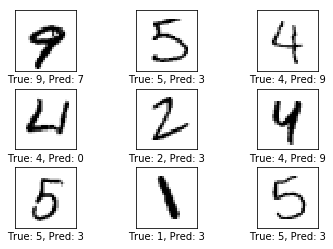

In [48]:
print_test_accuracy(show_example_errors=True)

## 1,000번 훈련 후의 성능

1,000번의 훈련 후에, 모델의 정확도는 크게 향상이 되어 90%이상의 정확도를 보이게 됩니다.

In [49]:
%%time
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  73.4%
Optimization Iteration:    201, Training Accuracy:  87.5%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  93.8%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  96.9%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  96.9%
CPU times: user 2min 11s, sys: 21.2 s, total: 2min 32s
Wall time: 38.6 s


Accuracy on Test-Set: 94.9% (9491 / 10000)
Example errors:


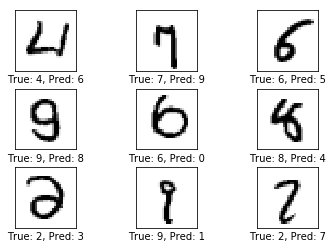

In [50]:
print_test_accuracy(show_example_errors=True)

## 10,000 회의 훈련 후의 성능

10,000번을 반복 훈련 한 후에는 테스트 세트의 데이터에 대해서 99%의 분류 정확도를 보여줍니다.

In [51]:
%%time
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy: 100.0%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy:  96.9%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  95.3%
Optimization Iteration:   1901, Training Accuracy:  96.9%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.9% (9890 / 10000)
Example errors:


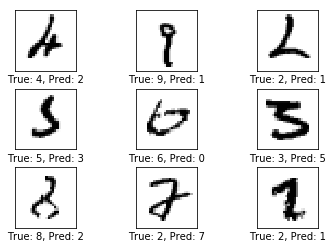

Confusion Matrix:
[[ 973    0    1    0    0    0    2    1    2    1]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   2    4 1021    0    1    0    0    2    2    0]
 [   0    0    0 1005    0    2    0    1    2    0]
 [   0    1    1    0  977    0    0    0    0    3]
 [   2    0    0    5    0  882    1    1    0    1]
 [   5    3    0    0    3    6  941    0    0    0]
 [   0    4    6    2    0    0    0 1010    1    5]
 [   2    1    1    2    0    1    0    1  964    2]
 [   0    7    0    0    9    2    0    3    4  984]]


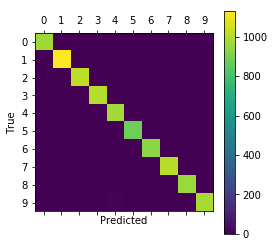

In [52]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## 가중치와 레이어의 시각화¶

### 컨볼루션 레이어의 가중치를 시각화 하기 위한 도움 함수

In [53]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 컨볼루션 레이어의 출력을 표시하기 위한 도움 함수

In [54]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 입력 이미지¶

이미지 표시를 위한 도움 함수

In [55]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

아래 예제처럼 사용될 테스트 세트의 이미지를 표시합니다.

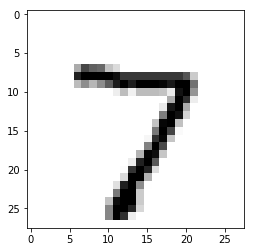

In [56]:
image1 = data.test.images[0]
plot_image(image1)

테스트 세트의 다른 이미지를 표시합니다.

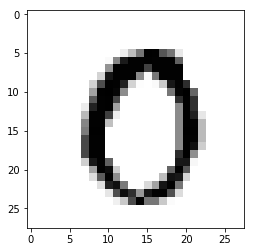

In [57]:
image2 = data.test.images[13]
plot_image(image2)

### 컨볼루션 레이어 1

이제 첫 번째 컨볼루션 레이어에 대한 필터 가중치를 그립니다.

양의 가중치는 빨간색이고 음수 가중치는 파란색입니다.

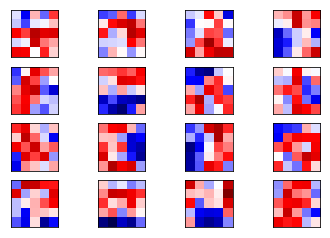

In [58]:
plot_conv_weights(weights=weights_conv1)

이들 컨볼루션 필터 각각을 첫번째 입력 이미지에 적용하면 다음의 출력 이미지가 얻어지며, 그 다음에 두번째 컨볼루션 레이어에 대한 입력으로 사용됩니다.

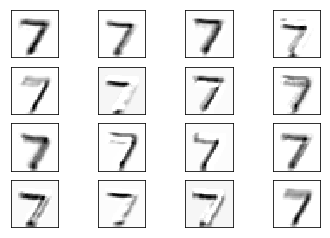

In [59]:
plot_conv_layer(layer=layer_conv1, image=image1)

다음 이미지는 컨볼루션 필터를 두 번째 이미지에 적용한 결과입니다.

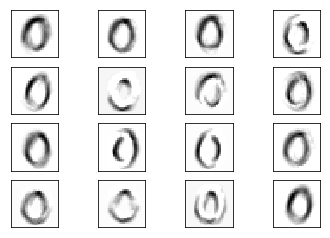

In [60]:
plot_conv_layer(layer=layer_conv1, image=image2)

### 컨볼루션 레이어 2

이제 두 번째 컨볼루션 레이어의 필터 가중치를 그립니다.

첫 번째 컨볼루션 레이어에는 16 개의 출력 채널이 있으며 이는 두 번째 컨볼루션 레이어에 16 개의 입력 채널이 있습니다. 두 번째 컨볼루션 레이어에는 각 입력 채널에 대한 일련의 필터 가중치가 있습니다. 우리는 첫 번째 채널에 대해 필터 가중치를 시각화 합니다.

양의 가중치는 빨간색이고 음수 가중치는 파란색입니다.

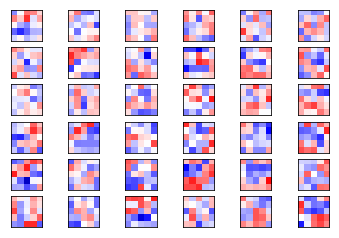

In [61]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

두 번째 컨볼루션 계층에는 16 개의 입력 채널이 있으므로 이와 같이 15 개의 필터 가중치를 추가로 만들 수 있습니다. 우리는 두 번째 채널에 대한 필터 가중치로 하나 더 만듭니다.

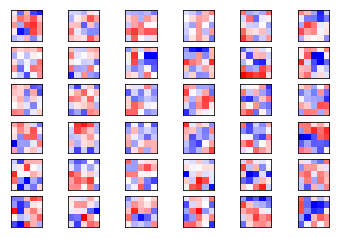

In [62]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

높은 차원 때문에 이러한 필터가 적용되는 방법을 이해하고 추적하는 것은 어려울 수 있습니다.

첫 컨볼루션 레이어에서 출력 된 이미지에 컨볼루션 필터를 적용하면 다음 이미지가 표시됩니다.

첫 번째 컨볼루션 레이어 다음에 스트라이드 2가 있는 max-pooling 레이어가 있기 때문에 원본 입력 이미지의 해상도의 절반인 14 x 14 픽셀로 다운 샘플링됩니다. 최대 풀링은 두 번째 컨벌루션 이후에도 수행되는데, 아래의 이미지는 적용되기 전에 뽑아낸 것 입니다.

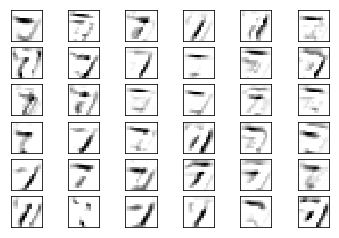

In [63]:
plot_conv_layer(layer=layer_conv2, image=image1)

그리고 다음이 두 번째 이미지에 필터 가중치를 적용한 결과입니다.

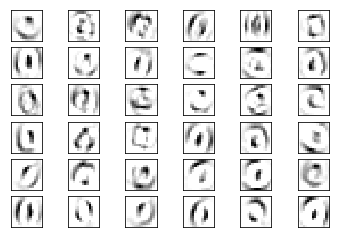

In [64]:
plot_conv_layer(layer=layer_conv2, image=image2)

### TensorFlow Session 닫기

TensorFlow를 사용하여 작업을 마쳤으므로 세션을 닫아 리소스를 해제합니다.

In [65]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## 결론

이 튜토리얼에서는 TensorFlow에서 컨볼루션 신경망을 쉽게 구축하기 위해 *Layers API*를 사용하는 방법을 설명했습니다. 구문은 PrettyTensor의 구문과 다르며 보다 장황합니다. 두 빌더 API에는 장점과 단점이 있지만 PrettyTensor는 한 사람 만 개발하고 Layers API는 이제 TensorFlow Core의 공식적인 부분이므로 PrettyTensor는 향후 더 이상 사용되지 않을 수 있습니다. 이러한 상황이 발생하면 독특하고 우아한 기능 중 일부가 TensorFlow Core에도 통합되기를 바랍니다.

저는 거의 1 년간 TensorFlow 개발자로부터 확실한 답을 얻으려고 노력했습니다. TensorFlow의 주요 API는 TensorFlow의 주요 빌더 API가 될 것입니다. 그것들은 여전히 미결정이며 구현이 매우 느린 것 같습니다.

## 연습문제

TensorFlow 활용 기술을 향상 시키는데 도움이 될 수 있는 몇 가지 제안 사항입니다. TensorFlow를 제대로 사용하는 방법을 배우려면 실습 경험을 얻는 것이 중요합니다.

변경하기 전에이 노트북을 백업 해 두기를 권장합니다.

* 일부 레이어의 활성화 함수를 시그모이 드로 변경합니다.
* 모든 레이어에 대해 활성화 함수를 변경하는 간단한 방법을 찾을 수 있습니까?
* 완전히 연결된 레이어 뒤에 드롭 아웃 레이어를 추가합니다. 훈련 및 테스트 중에 다른 확률을 원한다면 placeholder 변수가 필요하며 feed-dict를 사용하십시요.
* 컨볼루션레이어 대신에 max-pooling 레이어의 출력을 시각화 합니다.
* 컨벌루션 레이어에서 2x2 max-pooling 레이어를 stride = 2로 바꿉니다. 분류 정확도에 차이가 있습니까? 계속해서 또 다시 최적화하면 어떨까요? 차이는 무작위 적입니다. 그래서 실제로 차이가 있다면 어떻게 측정합니까? 컨볼루션 레이어에서 max-pooling과 stride의 장점과 단점은 무엇입니까?
* 레이어의 매개 변수를 변경합니다 (예 : 커널, 깊이, 크기 등 시간 사용 및 분류 정확도의 차이점은 무엇입니까?
* 컨볼루션 레이어와 완전히 연결된 레이어를 여러개 추가하고 제거하십시오.
* 여전히 잘 수행 할 수있는 가장 단순한 네트워크는 무엇입니까?
* 컨볼루션 레이어의 bias 값을 검색하여 출력합니다. `get_weights_variable()`을 참고하세요.
* 이 소스 코드를 너무 많이 보지 않고 직접 프로그램을 다시 제작하십시오.
* 프로그램이 어떻게 작동하는지 동료에게 설명하십시오.

## 라이센스 (MIT)

저작권 (c) 2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

사용, 복사, 수정, 병합 할 수있는 권한을 포함하되 이에 국한되지 않고 소프트웨어를 취급하기 위해이 소프트웨어 및 관련 문서 파일 (이하 "소프트웨어")의 사본을 얻는 모든 사람에게 사용 권한이 무료로 부여됩니다 다음 조건에 따라 소프트웨어의 사본을 게시, 배포, 재 라이센스 또는 판매 할 수 있고 소프트웨어를 제공받는 사람에게 허용 할 수 있습니다.

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야합니다.

소프트웨어는 상품성, 특정 목적에의 적합성 및 비 침해에 대한 보증을 포함하여 (단, 이에 한하지 않음) 묵시적이든 명시적이든 어떠한 종류의 보증없이 "있는 그대로"제공됩니다. 제작자 또는 저작권 보유자는 소프트웨어 또는 사용과 관련하여 발생했거나 또는 기타 행위로 인해 발생한 청구, 기타 책임에 대해 어떠한 경우에도 책임을지지 않습니다.